In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
# sys.path.append(os.path.abspath(os.path.join('./scripts')))
import pandas as pd
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import os
import pickle
import pandas as pd
from collections import Counter
import librosa
import librosa.display
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import backend as K
from jiwer import wer
import random
import mlflow
import warnings
warnings.filterwarnings('ignore')
import helper
from data_generator import DataGenerator
from tokenizer import Tokenizer
from logspectrogram import LogMelSpectrogram
from ctc_loss import CTC_loss
from model2 import simple_rnn_model, CNN_net, BidirectionalRNN2, cnn_rnn_model, preprocessin_model

In [10]:
frame_step = 256
ctc = CTC_loss(frame_step)

In [11]:
### Model trainer function

In [13]:
def train(model_builder,
          data_gen,
          batch_size = 32,
          epochs=20,
          verbose=1,
          save_path="../models/model.h5",
          optimizer=SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
          ):

    model = ctc.add_ctc_loss(model_builder)

    checkpointer = ModelCheckpoint(filepath=save_path, verbose=0)
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    print(model.summary())


    hist = model.fit_generator(generator=data_gen,
                               callbacks=[checkpointer],

                               epochs=epochs,
                               verbose=verbose,
                               use_multiprocessing=False)
    return model

In [16]:
translation_obj = helper.read_obj("../data/translation_dict.pkl")
audio_obj = helper.read_obj("../data/audio_dict.pkl")
meta_data = helper.read_csv("../data/meta_data.csv")

file read as csv


In [17]:
sorted_metadata = meta_data.sort_values(by="duration")
labels = sorted_metadata['label'].to_list()
sorted_metadata

,translation,label,channel,sample_rate,duration
3399,እኔ ጥሩ ኢትዮጵያዊ ነኝ,tr_7742_tr78043,1,8000,1.792
3922,ጺ ዮን ማሪያም ሄጄ ነበር,tr_8210_tr82091,1,8000,2.048
1142,ሼራተን አዲስ ተመረቀ,tr_5302_tr54003,1,8000,2.048
3097,አሸናፊ ፈጣን ተጨዋች ነው,tr_1541_tr16042,1,8000,2.048
1244,ዛሬ አዲስ ክስተት አለ,tr_6251_tr63052,1,8000,2.176
...,...,...,...,...,...
1785,የ ትምህርት ደረጃቸው ንና የ አገልግሎት ሁኔታዎች ን ስን መረምር የሚደር...,tr_2365_tr24066,1,8000,19.968
555,ለ ምሳሌ ዲዮ ን ደብሊን ን ፓትሪክ ኩላይቨርት ን ን ሮናልድ ዴ ቦዬርን ...,tr_85_tr01085,1,8000,20.480
4255,ሁሴን አይዲድ እንደ ገለጹት ኢትዮጵያ ሁኔታዎች ከ ተመቻቹ ላት ሶማሊያ ን...,tr_16_tr01016,1,8000,20.736
4524,ባጭሩ ድርጅታችን እየ በ ከተ ስርአታችን ና አመራ ራችን ባህርይ ውን እየ...,tr_6163_tr62064,1,8000,22.528


In [19]:
audios = []
for label in labels:
    audios.append(audio_obj[label][0])

translations = []
for label in labels:
    translations.append(translation_obj[label])

In [20]:
def build_model(output_dim, custom_model, preprocess_model, mfcc=False, calc=None):

    input_audios = Input(name='the_input', shape=(None,))
    pre = preprocess_model(input_audios)
    pre = tf.squeeze(pre, [3])

    y_pred = custom_model(pre)
    model = Model(inputs=input_audios, outputs=y_pred, name="model_builder")
    model.output_length = calc

    return model

In [22]:
def predict(model, audio, tokenizer, int_to_char, actual=None):

    pred_audios = tf.convert_to_tensor([audio])

    y_pred = model.predict(pred_audios)

    input_shape = tf.keras.backend.shape(y_pred)
    input_length = tf.ones(shape=input_shape[0]) * tf.keras.backend.cast(input_shape[1], 'float32')
    prediction = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=False)[0][0]

    pred = K.eval(prediction).flatten().tolist()
    pred = [i for i in pred if i != -1]

    predicted_text = tokenizer.decode_text(pred, int_to_char)

    error = None
    if actual != None:
        error = wer(actual, predicted_text)

    return predicted_text, error

In [23]:
tokenizer = Tokenizer(translations)
int_to_char, char_to_int = tokenizer.build_dict()
sample = translations[0]
encoded = tokenizer.encode(sample, char_to_int)
decoded = tokenizer.decode_text(encoded, int_to_char)

print(f"sample snt: {sample}")
print(f"encoded snt: {encoded}")
print(f"decoed snt: {decoded}")

sample snt: እኔ ጥሩ ኢትዮጵያዊ ነኝ
encoded snt: [13, 106, 1, 44, 52, 1, 35, 3, 38, 43, 6, 63, 1, 20, 99]
decoed snt: እኔ ጥሩ ኢትዮጵያዊ ነኝ


In [24]:
helper.write_obj("../int_to_char.pkl", int_to_char)
helper.write_obj("../char_to_int.pkl", char_to_int)

In [25]:
sample_rate = 8000
fft_size = 512
frame_step = 256
n_mels = 128
batch_size = 100
epochs = 20
data_len = len(translations)
output_dim = len(char_to_int) + 2

In [28]:
dg = DataGenerator(translations, audios, batch_size, shuffle=True)
preprocess_model = preprocessin_model(sample_rate, fft_size, frame_step, n_mels)
preprocess_model.summary()

2022-06-08 22:55:16.957528: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "preprocessin_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 log_mel_spectrogram (LogMel  (None, None, 128, 1)     0         
 Spectrogram)                                                    
                                                                 
 batch_normalization (BatchN  (None, None, 128, 1)     512       
 ormalization)                                                   
                                                                 
Total params: 512
Trainable params: 256
Non-trainable params: 256
_________________________________________________________________


(1, 25600)


(1, 99, 128, 1)

char_len 39


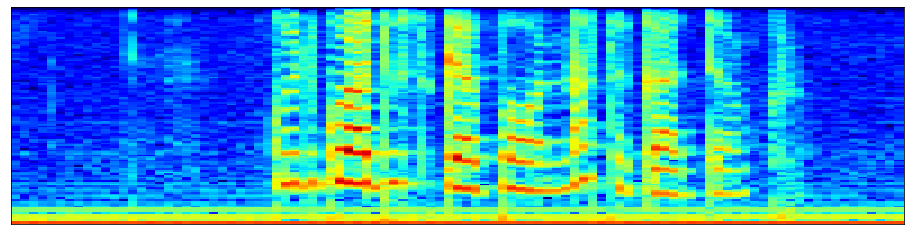

In [32]:
sample_audio = dg[0][0]['the_input'][0].numpy()
sample_lbl = dg[0][0]['the_labels'][0].numpy()

a = np.zeros((1, len(sample_audio)))
a[0, ] = sample_audio
print(a.shape)
pred = preprocess_model.predict(a)
fig, ax = plt.subplots(figsize=(16, 4))
display(pred.shape)
pred = pred[0, :, :, 0]
librosa.display.specshow(pred.T, sr=8000, hop_length=128, cmap="jet")
print("char_len", len(sample_lbl))

(1, 183296)


(1, 715, 128, 1)

char_len 163


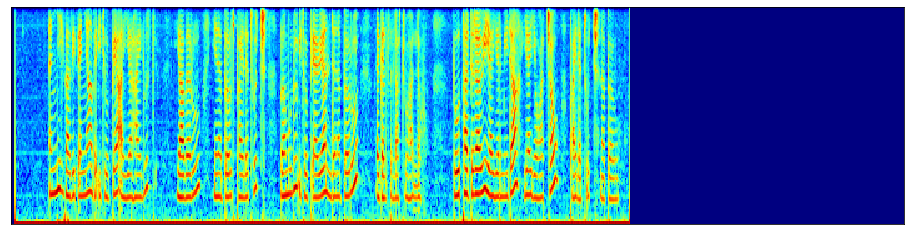

In [33]:

sample_audio = dg[49][0]['the_input'][-1].numpy()
sample_lbl = dg[49][0]['the_labels'][-1].numpy()

a = np.zeros((1, len(sample_audio)))
a[0, ] = sample_audio
print(a.shape)
pred = preprocess_model.predict(a)
fig, ax = plt.subplots(figsize=(16, 4))
display(pred.shape)
pred = pred[0, :, :, 0]
librosa.display.specshow(pred.T, sr=8000, hop_length=128, cmap="jet")
print("char_len", len(sample_lbl))

## Simple RNN

In [34]:
speech_simple_rnn = simple_rnn_model(n_mels, output_dim)
speech_simple_rnn.summary()

Model: "simple_rnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 128)]       0         
                                                                 
 rnn (GRU)                   (None, None, 224)         237888    
                                                                 
 softmax (Activation)        (None, None, 224)         0         
                                                                 
Total params: 237,888
Trainable params: 237,888
Non-trainable params: 0
_________________________________________________________________


In [35]:
simple_rnn_speech_model = build_model(output_dim, speech_simple_rnn, preprocess_model)
simple_rnn_speech_model.summary()

Model: "model_builder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None)]            0         
                                                                 
 preprocessin_model (Functio  (None, None, 128, 1)     512       
 nal)                                                            
                                                                 
 tf.compat.v1.squeeze (TFOpL  (None, None, 128)        0         
 ambda)                                                          
                                                                 
 simple_rnn_model (Functiona  (None, None, 224)        237888    
 l)                                                              
                                                                 
Total params: 238,400
Trainable params: 238,144
Non-trainable params: 256
_____________________________________________

#### Train and Export Model

In [21]:
train(simple_rnn_speech_model, dg, epochs=20, save_path="../models/simple_rnn_model.h5",  batch_size=batch_size)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 preprocessin_model (Functional  (None, None, 128, 1  512        ['the_input[0][0]']              
 )                              )                                                                 
                                                                                                  
 tf.compat.v1.squeeze (TFOpLamb  (None, None, 128)   0           ['preprocessin_model[0][0]']     
 da)                                                                                              
                                                                                              

#### Predicting Using Simple RNN

In [36]:
simple_rnn_speech_model.load_weights("../models/simple_rnn_model.h5")
actual_translation = translations[10]
sample_test_audio = audios[0]
predicted, error = predict(simple_rnn_speech_model, sample_test_audio , tokenizer, int_to_char, actual=actual_translation)

print("actual", actual_translation)
print("predicted", predicted)
print("WER: ", error)

2022-06-08 23:03:31.465966: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 2200 num_cores: 12 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 9437184 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


actual በ ባህል በ ቋንቋ አንድ ናቸው
predicted በትንትን ንያትንትንስንትንትንትንየንየትንትን
WER:  1.0


## CNN + Simple RNN

In [38]:
speech_cnn_rnn = cnn_rnn_model(n_mels, 250, 4, 1, 'same', 400, output_dim)
speech_cnn_rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None, 128)]       0         
                                                                 
 conv1d (Conv1D)             (None, None, 250)         128250    
                                                                 
 bn_conv_1d (BatchNormalizat  (None, None, 250)        1000      
 ion)                                                            
                                                                 
 rnn (SimpleRNN)             (None, None, 400)         260400    
                                                                 
 batch_normalization_1 (Batc  (None, None, 400)        1600      
 hNormalization)                                                 
                                                                 
 time_distributed (TimeDistr  (None, None, 224)        89824 

In [39]:
speech_cnn_rnn_model = build_model(output_dim, speech_cnn_rnn, preprocess_model)
speech_cnn_rnn_model.summary()

Model: "model_builder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, None)]            0         
                                                                 
 preprocessin_model (Functio  (None, None, 128, 1)     512       
 nal)                                                            
                                                                 
 tf.compat.v1.squeeze_1 (TFO  (None, None, 128)        0         
 pLambda)                                                        
                                                                 
 model (Functional)          (None, None, 224)         481074    
                                                                 
Total params: 481,586
Trainable params: 480,030
Non-trainable params: 1,556
_________________________________________________________________


#### Train and Export Model

In [32]:
train(speech_cnn_rnn_model, dg, epochs=20, save_path="../models/cnn_rnn_model.h5",  batch_size=batch_size)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 the_input (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 preprocessin_model (Functional  (None, None, 128, 1  512        ['the_input[0][0]']              
 )                              )                                                                 
                                                                                                  
 tf.compat.v1.squeeze_1 (TFOpLa  (None, None, 128)   0           ['preprocessin_model[1][0]']     
 mbda)                                                                                            
                                                                                            

#### Predicting Using CNN + Simple RNN

In [33]:
speech_cnn_rnn_model.load_weights("../models/cnn_rnn_model.h5")
for k in range(10):
    i = random.randint(0, 3000)
    actual_translation = translations[i]
    sample_test_audio = audios[i]
    predicted, error = predict(speech_cnn_rnn_model, sample_test_audio,
                               tokenizer, int_to_char, actual=actual_translation)

    print("actual", actual_translation)
    print("predicted", predicted)
    print(f"WER: {error:.2f}")
    print()

1/1 [==============================] - 1s 822ms/step
actual የ ኤርትራውያን በ ቅርቡ በ ቡሬ በኩል መባረር የ ጄኔቫ ን ኮንቬንሽን የሚ ጥስ ነው አላልኩ ም
predicted  ተረ ናን ደ ቀኖ ተንኮ ታር ን መንኮንሚ ንሽ ሚ ና ረር 
WER: 0.94

1/1 [==============================] - 1s 508ms/step
actual ሳምንት በ ኦልድ ትራ ፎርድ ሊድስ ን አስተናግ ዶ ሶስት ለ ሁለት አሸን ፏል
predicted ሳ ንት በል ትላፎርች ሌስ አስተቅድሶስት ለ ውለት ታሸንነ ፏል
WER: 0.86

1/1 [==============================] - 0s 42ms/step
actual በ ቤተ ክህነት ሹም ሽር ተደረገ
predicted በ ሜተ ክ ነዲ ሽን ሽር ተዳረየ ገ
WER: 1.00

1/1 [==============================] - 0s 34ms/step
actual መንግስት የ ብሮድካስት ን አዋጅ ን ተግባራዊ እንዲያደርግ ተ ጠይቋል
predicted መንግርስቴ የ ብ ደ ካርሰን አዋንል ተግባራዊ ን ጀያ ደት ትዳኢ ቋል
WER: 1.00

1/1 [==============================] - 0s 45ms/step
actual ኦነግ ና ኦብነግ ቁርሾ ጀመሩ
predicted ጻ አሆ የ ገ ን ሚማ ሁ ባና እንድ ደ ሽ ጃ ሚ ላር 
WER: 2.80

1/1 [==============================] - 0s 32ms/step
actual ኢትዮጵያ በ ዛላንበሳ የ በላይነት እ ያገኘች መምጣቷ ን ነጻ ምንጮች አ ረጋገጡ
predicted ሊኢትዮጵያ በዛዋ በሰ የበ የነ ት ያ ገኛ መ ምዳቷን ነም ደች አረጋ ገት
WER: 1.08

1/1 [==============================] - 0s 48ms